In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-sys-1-1-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

In [4]:

def modeling(name):
    
    ' ----- read data ----- '
    
    chi2_red_new_cut = 0.8

    with tables.open_file(data_dir+'data_full_h5/'+name+'.h5','r') as f:
        CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
        CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
        CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
        CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
        CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
        CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1

        CUT_antistoch = (np.log10(f.root.Collection.cols.chi2_red_new[:]) < chi2_red_new_cut)

        CUT =  CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_antistoch

        zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
        truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
        len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
        closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
        d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
        d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
        Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

        passed_2 = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool)[CUT] # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
        passed_3 = (f.root.IT_veto_double.cols.flag_window_3[:]).astype(bool)[CUT]
        passed_4 = (f.root.IT_veto_double.cols.flag_window_4[:]).astype(bool)[CUT]
        passed_5 = (f.root.IT_veto_double.cols.flag_window_5[:]).astype(bool)[CUT]
    
    ' *** use 2 pulse threshold ***'
    passed_n = passed_2
    Npulse = 2
    
    ' ----- 1. find best exponent p ----- '

    dist_bins = np.linspace(0,2500,100)
    energy_bins = np.arange(5.5,6.2,0.1) 
    
    expos = []
    devs = []
    for expo in np.arange(4,8,0.1):
        chisqr_n = [] # goodness of fit
        for b in range(0,len(energy_bins)-1): # in each energy range [E1,E2]
            # energy cut 
            CUT_energy_bin = (np.log10(truncated_muon_e_data_burn)>energy_bins[b])&(np.log10(truncated_muon_e_data_burn)<energy_bins[b+1])
            d_to_IT_center_binned = d_to_IT_center_data_burn[CUT_energy_bin]
            passed_n_binned = passed_n[CUT_energy_bin] # events that pass the veto (not rejected)

            h_total,dist_n = np.histogram(d_to_IT_center_binned,bins=dist_bins)
            h_pass,dist_n = np.histogram(d_to_IT_center_binned[passed_n_binned],bins=dist_bins)
            cut = (h_pass>0) & (h_total>0) # remove empty bins / all vetoed bins 
            dist_n = ((dist_n[1:] + dist_n[:-1])/2)[cut]
            ineff_n = (h_pass/h_total)[cut]
            ineff_n_err = (h_pass/h_total * np.sqrt(1/h_pass + 1/h_total))[cut]

            def ineff_model_npulse(x,a,b):
                return a * np.exp(-b/(x/2000)**(expo)) # asymptotic. Exponent depends on N pulse threshold! [4.5 for 2 pulse]

            p_init = [0.8, 0.05]    
            p_bounds = [[0,0],[1,1]]
            popt, pcov = curve_fit(ineff_model_npulse,dist_n,ineff_n,sigma=ineff_n_err,p0=p_init,bounds=p_bounds)
            chisqr_n = np.append( chisqr_n, 1/(len(ineff_n_err)-2)*np.sum( ((ineff_model_npulse(dist_n,*popt) - ineff_n)/ineff_n_err)**2 ))

        dev = np.sum((chisqr_n - 1)**2) # find total deviation from chisqr=1

        expos = np.append(expos, expo)
        devs = np.append(devs, dev)
    best_expo = expos[devs == np.min(devs)][0]
#     plt.plot(expos,devs,'o-')
#     plt.yscale('log')
    print('best exponent = ',str(best_expo))
    
    ' ----- 2. start fitting as a function of distance -----'
    # store params for each energy bin 
    energy_coord = []
    param_passed_n_a = [] 
    param_passed_n_a_err = []
    param_passed_n_b = [] 
    param_passed_n_b_err = []
    chisqr_n = [] # goodness of fit

    for b in range(0,len(energy_bins)-1): # in each energy range [e1,e2]

        # energy cut 
        CUT_energy_bin = (np.log10(truncated_muon_e_data_burn)>energy_bins[b])&(np.log10(truncated_muon_e_data_burn)<energy_bins[b+1])
        d_to_IT_center_binned = d_to_IT_center_data_burn[CUT_energy_bin]
        passed_n_binned = passed_n[CUT_energy_bin] # events that pass the veto (not rejected)

        h_total,dist_n = np.histogram(d_to_IT_center_binned,bins=dist_bins)
        h_pass,dist_n = np.histogram(d_to_IT_center_binned[passed_n_binned],bins=dist_bins)
        cut = (h_pass>0) & (h_total>0) # remove empty bins / all vetoed bins 
        dist_n = ((dist_n[1:] + dist_n[:-1])/2)[cut]
        ineff_n = (h_pass/h_total)[cut]
        ineff_n_err = (h_pass/h_total * np.sqrt(1/h_pass + 1/h_total))[cut]

        ##### fitting #####
        def ineff_model_npulse(x,a,b):
            return a * np.exp(-b/(x/2000)**(best_expo)) # asymptotic. Exponent depends on N pulse threshold! [4.5 for 2 pulse]

        p_init = [0.8, 0.05]    
        p_bounds = [[0,0],[1,1]]
        popt, pcov = curve_fit(ineff_model_npulse,dist_n,ineff_n,sigma=ineff_n_err,p0=p_init,bounds=p_bounds)

        # for energy fitting 
        energy_coord = np.append(energy_coord, (energy_bins[b]+energy_bins[b+1])/2)

        param_passed_n_a = np.append(param_passed_n_a,popt[0])
        param_passed_n_a_err = np.append(param_passed_n_a_err,np.sqrt(pcov[0,0]))
        param_passed_n_b = np.append(param_passed_n_b,popt[1])
        param_passed_n_b_err = np.append(param_passed_n_b_err,np.sqrt(pcov[1,1]))

        # compute chi2 goodness of fit for later (reduced chi2)
        chisqr_n = np.append( chisqr_n, 1/(len(ineff_n_err)-2)*np.sum( ((ineff_model_npulse(dist_n,*popt) - ineff_n)/ineff_n_err)**2 ))

        " ----- plot ineff vs. dist ----- "
        '''
        plt.rcParams.update({'font.size': 13})
        plt.figure(figsize=(14,5))

        plt.subplot(121)
        plt.axhline(0,ls='--',color='black',alpha=0.8)
        plt.axhline(1,ls='--',color='black',alpha=0.8)

        plt.errorbar(dist_n,ineff_n,yerr=ineff_n_err,fmt='s',alpha=0.5,label=str(Npulse)+' pulses, '+r'$\chi^2_{fit}=$'+str(np.round(chisqr_n[b],2)),color='steelblue')

        dist_dense = np.arange(0,2500,10)
        plt.plot(dist_dense,ineff_model_npulse(dist_dense,*popt),'--',lw=3,color='darkorange')

        plt.xlabel('distance from track to IT center [m]')
        plt.ylabel('IT Ineff')
        plt.xlim(0,2500)
        plt.ylim(-0.05,1.1)
        plt.title(r'$\log_{10}$E$\in$['+str(np.round(energy_bins[b],2))+', '+str(np.round(energy_bins[b+1],2))+']')
        plt.legend(loc='upper left',prop={'size': 9})

        plt.subplot(122)
        plt.axhline(0,ls='--',color='black',alpha=0.8)
        plt.axhline(1,ls='--',color='black',alpha=0.8)

        plt.errorbar(dist_n,ineff_n,yerr=ineff_n_err,fmt='s',alpha=0.5,label=str(Npulse)+' pulses, '+r'$\chi^2_{fit}=$'+str(np.round(chisqr_n[b],2)),color='steelblue')

        dist_dense = np.arange(0,2500,10)
        plt.plot(dist_dense,ineff_model_npulse(dist_dense,*popt),'--',lw=3,color='darkorange')

        plt.xlabel('distance from track to IT center [m]')
        plt.ylabel('log10 IT Ineff')
        plt.xlim(0,2500)
        plt.ylim(2*1e-4,2)
        plt.title(r'$\log_{10}$E$\in$['+str(np.round(energy_bins[b],2))+', '+str(np.round(energy_bins[b+1],2))+']')
        plt.legend(loc='lower right',prop={'size': 9})
        plt.yscale('log')

        plt.show()
        '''
    '----- 3. plot goodness of fit -----'
    '''
    plt.figure()
    plt.plot(energy_coord,chisqr_n,'o-',color='m')
    plt.xlabel('energy bin')
    plt.ylabel(r'$\chi^2_{red}$')
    plt.title('goodness of fit, '+str(Npulse)+' pulses')
    plt.ylim(0,10)
    plt.show()
    '''
    '----- 4. energy fitting -----' 
    
    def e_func(x,c,d,e): # polynomial
        return c*(x-d)**2 + e
    p_bounds = [[-10,4,0],[10,5.47,20]]

    popt_a, pcov_a = curve_fit(e_func,energy_coord,param_passed_n_a,sigma=param_passed_n_a_err,bounds=p_bounds)
    popt_b, pcov_b = curve_fit(e_func,energy_coord,param_passed_n_b,sigma=param_passed_n_b_err,bounds=p_bounds)

    print(popt_a)
    '''
    plt.figure(figsize=(15,5))

    # param a(c,d,e)
    plt.subplot(121)
    plt.errorbar(energy_coord,param_passed_n_a,yerr=param_passed_n_a_err,fmt='s',alpha=0.5,color='m',label=str(Npulse)+' pulses')
    energy_coord_dense = np.arange(5,8,0.1)
    plt.plot(energy_coord_dense,e_func(energy_coord_dense,*popt_a),'--',color='red')
    plt.xlim(5.5,7)
    plt.ylim(0.,1.1)
    plt.legend()
    plt.xlabel(r'$\log_{10}$ truncated muon energy')
    plt.ylabel('parameter a(E)')

    # param b(c,d,e)
    plt.subplot(122)
    plt.errorbar(energy_coord,param_passed_n_b,yerr=param_passed_n_b_err,fmt='s',alpha=0.5,color='m',label=str(Npulse)+' pulses')
    plt.plot(energy_coord_dense,e_func(energy_coord_dense,*popt_b),'--',color='red')
    plt.xlim(5.5,7)
    plt.ylim(-0.1,0.8)
    plt.legend()
    plt.xlabel(r'$\log_{10}$ truncated muon energy')
    plt.ylabel('parameter b(E)')

    plt.show()
    '''
    " ----- Save IT Ineff Model ----- "

    # f = ineff(dist,A,B,C) where A = e_func(Energy,C,D,E), etc
    def IT_model(dist,E): 
        A = e_func(E,*popt_a)
        B = e_func(E,*popt_b)
        tmp = ineff_model_npulse(dist,A,B)
        tmp[tmp<0] = 0
        return tmp

    # SAVING 2 pulses model parameters to file!! 
#     model_file = open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust.txt','w')
#     L = [str(popt_a[0])+'\n',str(popt_a[1])+'\n',str(popt_a[2])+'\n',
#          str(popt_b[0])+'\n',str(popt_b[1])+'\n',str(popt_b[2])+'\n', 
#         ]
#     model_file.writelines(L) 
#     model_file.close()

    # 2d pcolor with contour  

    xt = np.linspace(0.001,2500,100) # dist 
    yt = np.linspace(5.5,7,100)  # E 
    xg,yg = np.meshgrid(xt,yt)
    zg = IT_model(xg,yg)

    # if ineff < 0, change to 0! 
    zg[zg<0] = 0

    ##### data model comparison
    
    dist_bins = np.linspace(0,2500,100)
    energy_bins = np.linspace(5.5,7,100)

    plt.figure(figsize=(20,7))
    plt.subplot(121)
    t = np.arange(0,2500,1)
    lowstat = 5.47+2*np.sqrt(1 - ((t-20)/2210)**2)
    plt.plot(t,lowstat,color='black')
    h_before,x,y=np.histogram2d(d_to_IT_center_data_burn,np.log10(truncated_muon_e_data_burn),bins=[dist_bins,energy_bins],range=([[0,2500],[5.5,7]]))
    h_after,x,y=np.histogram2d(d_to_IT_center_data_burn[passed_n],np.log10(truncated_muon_e_data_burn)[passed_n],bins=[dist_bins,energy_bins],range=([[0,2500],[5.5,7]]))
    ineff = (h_after/h_before).T

    plt.plot(t,lowstat,color='black')
    my_cmap = matplotlib.cm.get_cmap('rainbow')
    my_cmap.set_under('w')
    plt.pcolormesh(x,y,ineff,cmap=my_cmap)
    plt.colorbar()
    CS=plt.contour(ineff,extent=[0,2500,5.5,7],levels=[0.2,0.4,0.6,0.8])
    plt.clabel(CS,inline=1,fmt='%1.1f',fontsize=10)
    plt.clim(0,1)
    plt.xlabel('distance from track to IT center [m]')
    plt.ylabel('log(truncated muon energy)')
    plt.xlim(0,2500)
    plt.ylim(5.5,7)
    plt.title('IT Ineff from data, '+str(Npulse)+' pulses')
    
    plt.subplot(122)
    plt.plot(t,lowstat,color='black')
    plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
    plt.colorbar()
    plt.clim(0,1)
    CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)

    plt.xlabel('distance from track to IT center [m]')
    plt.ylabel('log(truncated muon energy)')
    plt.xlim(0,2500)
    plt.ylim(5.5,7)
    plt.title('IT Inefficiency Model using '+str(Npulse)+' pulses')
    plt.show()

    return IT_model, CS

<>:157: DeprecationWarning: invalid escape sequence \c
<>:203: DeprecationWarning: invalid escape sequence \l


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply


best exponent =  6.299999999999992
[-0.71571297  5.30527515  0.65780159]


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:240: RuntimeWarning: invalid value encountered in sqrt


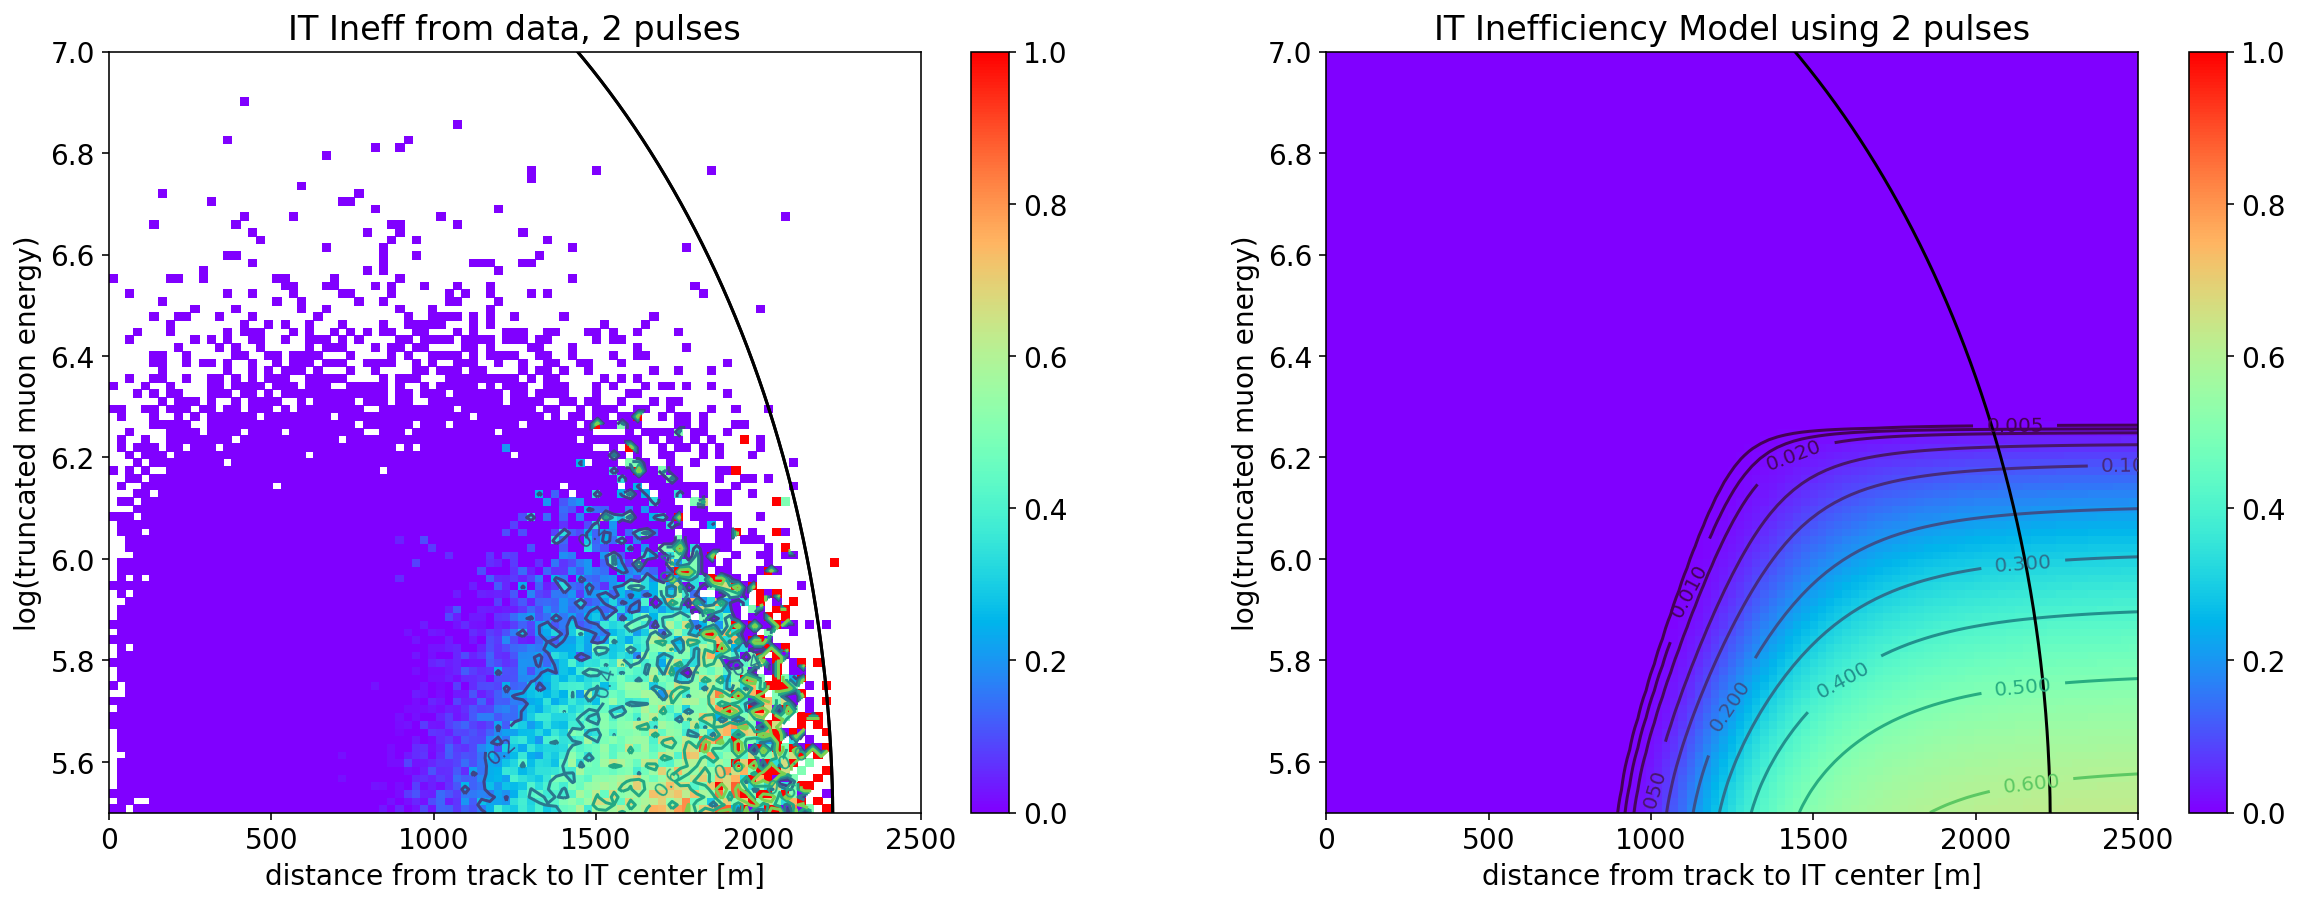

best exponent =  7.299999999999988
[-0.21270605  4.          1.11255749]


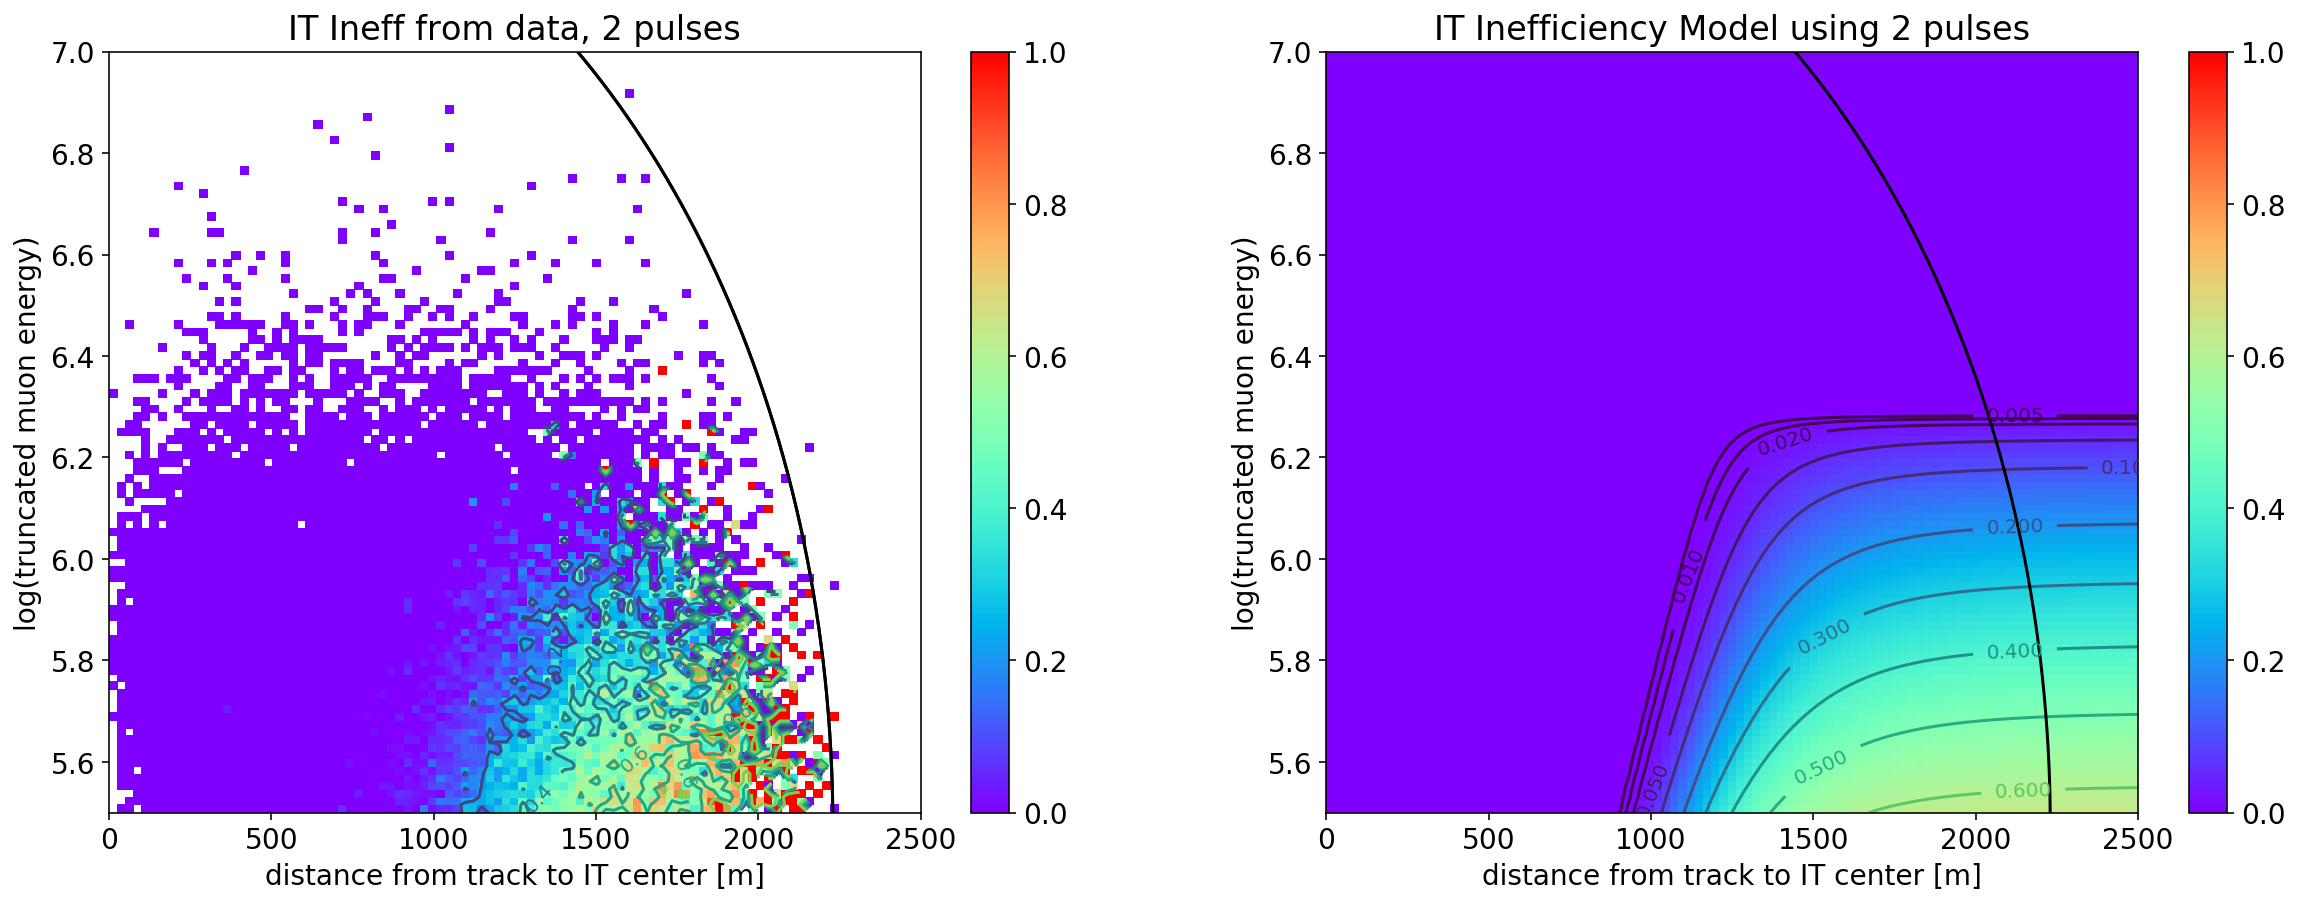

best exponent =  6.79999999999999
[-0.31183839  4.56664191  0.95270474]


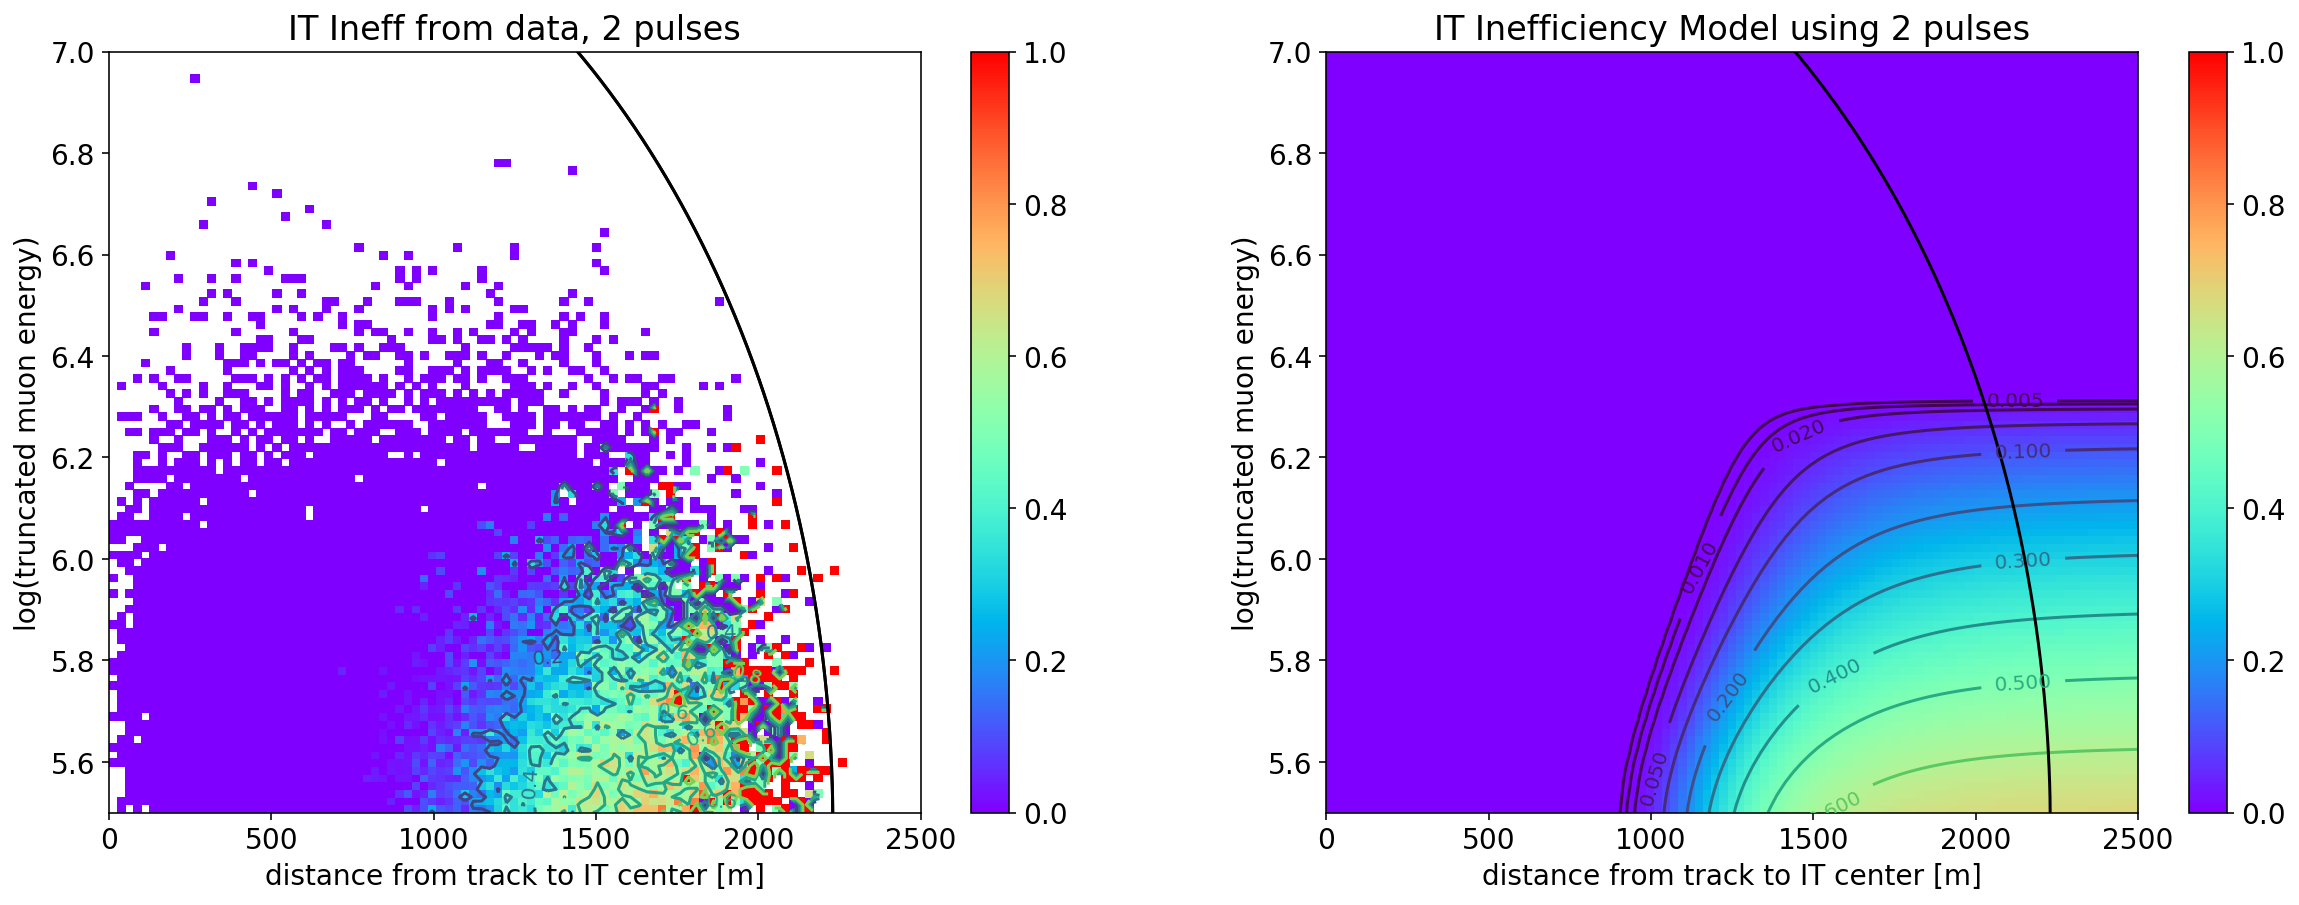

best exponent =  6.599999999999991
[-0.52660077  5.07736186  0.76923105]


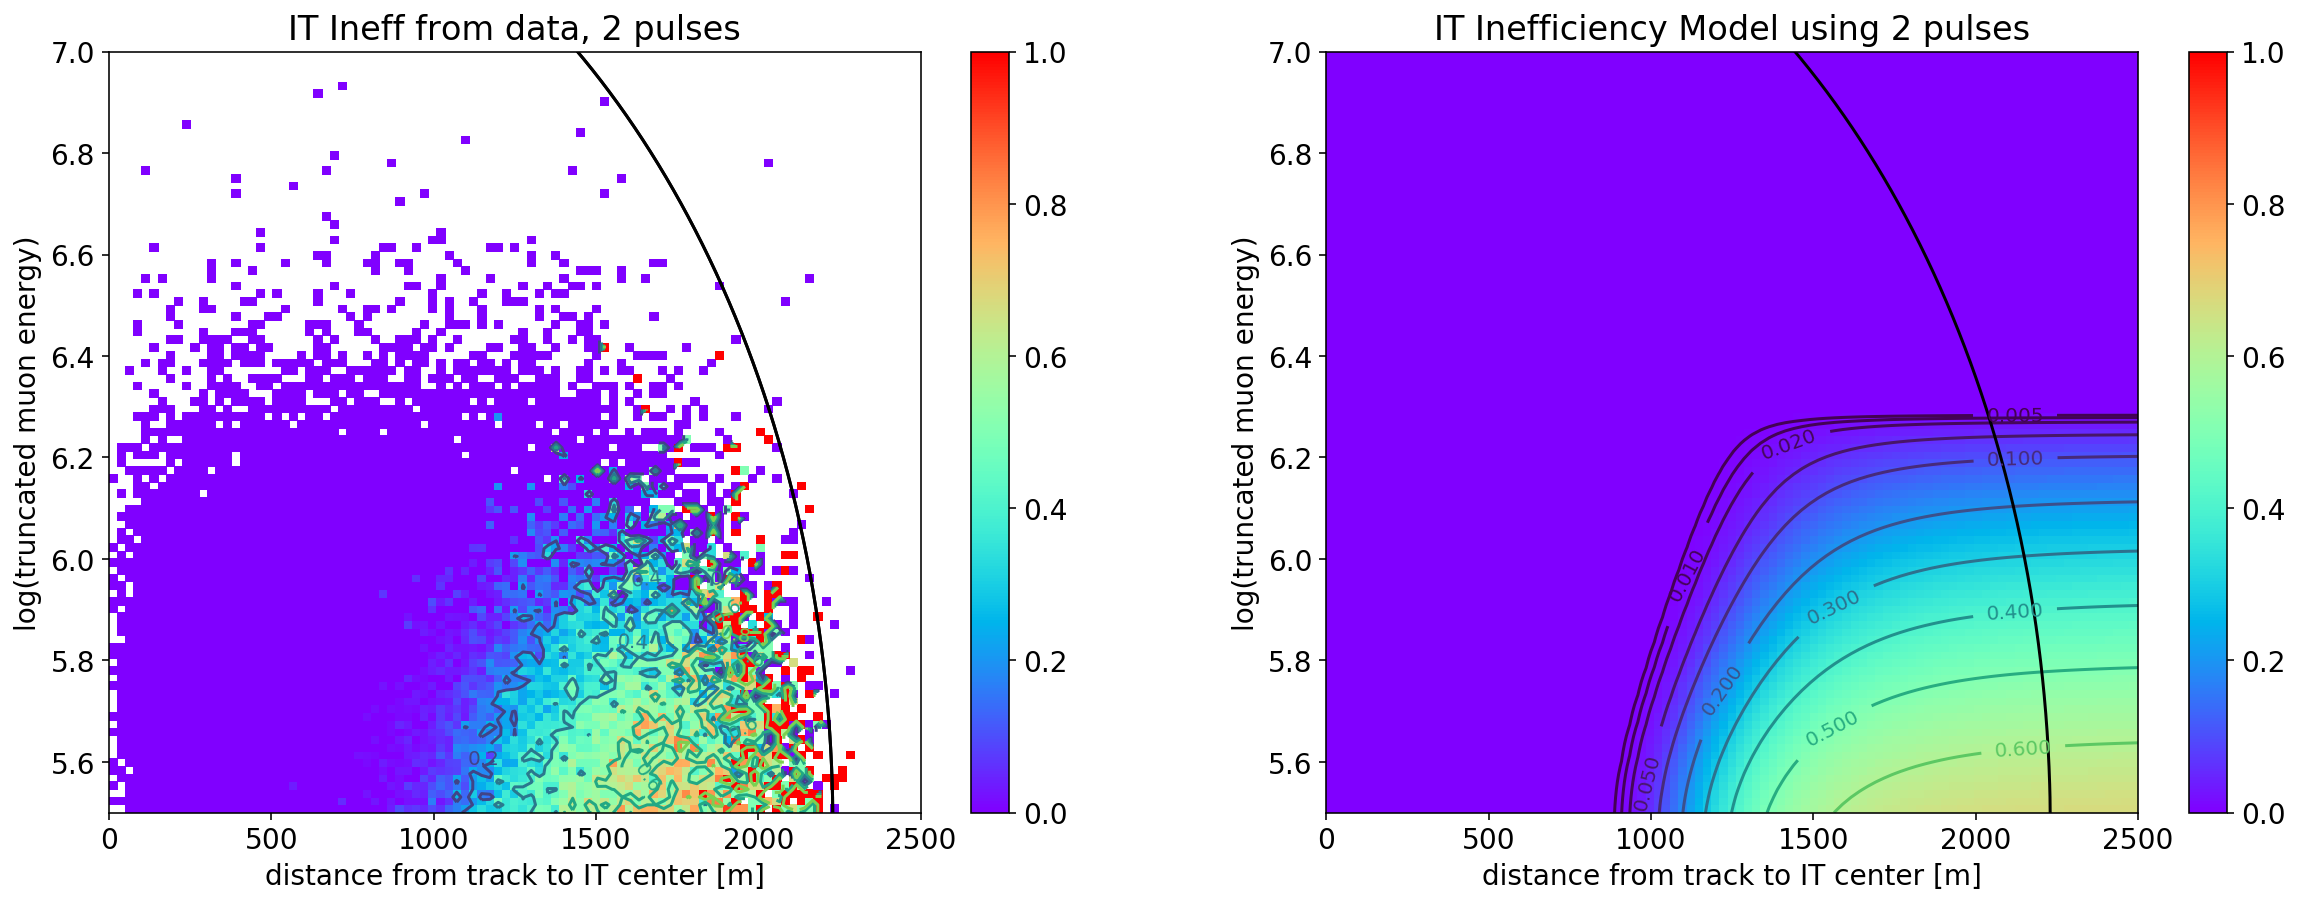

best exponent =  6.3999999999999915
[-1.06001599  5.41994754  0.68755868]


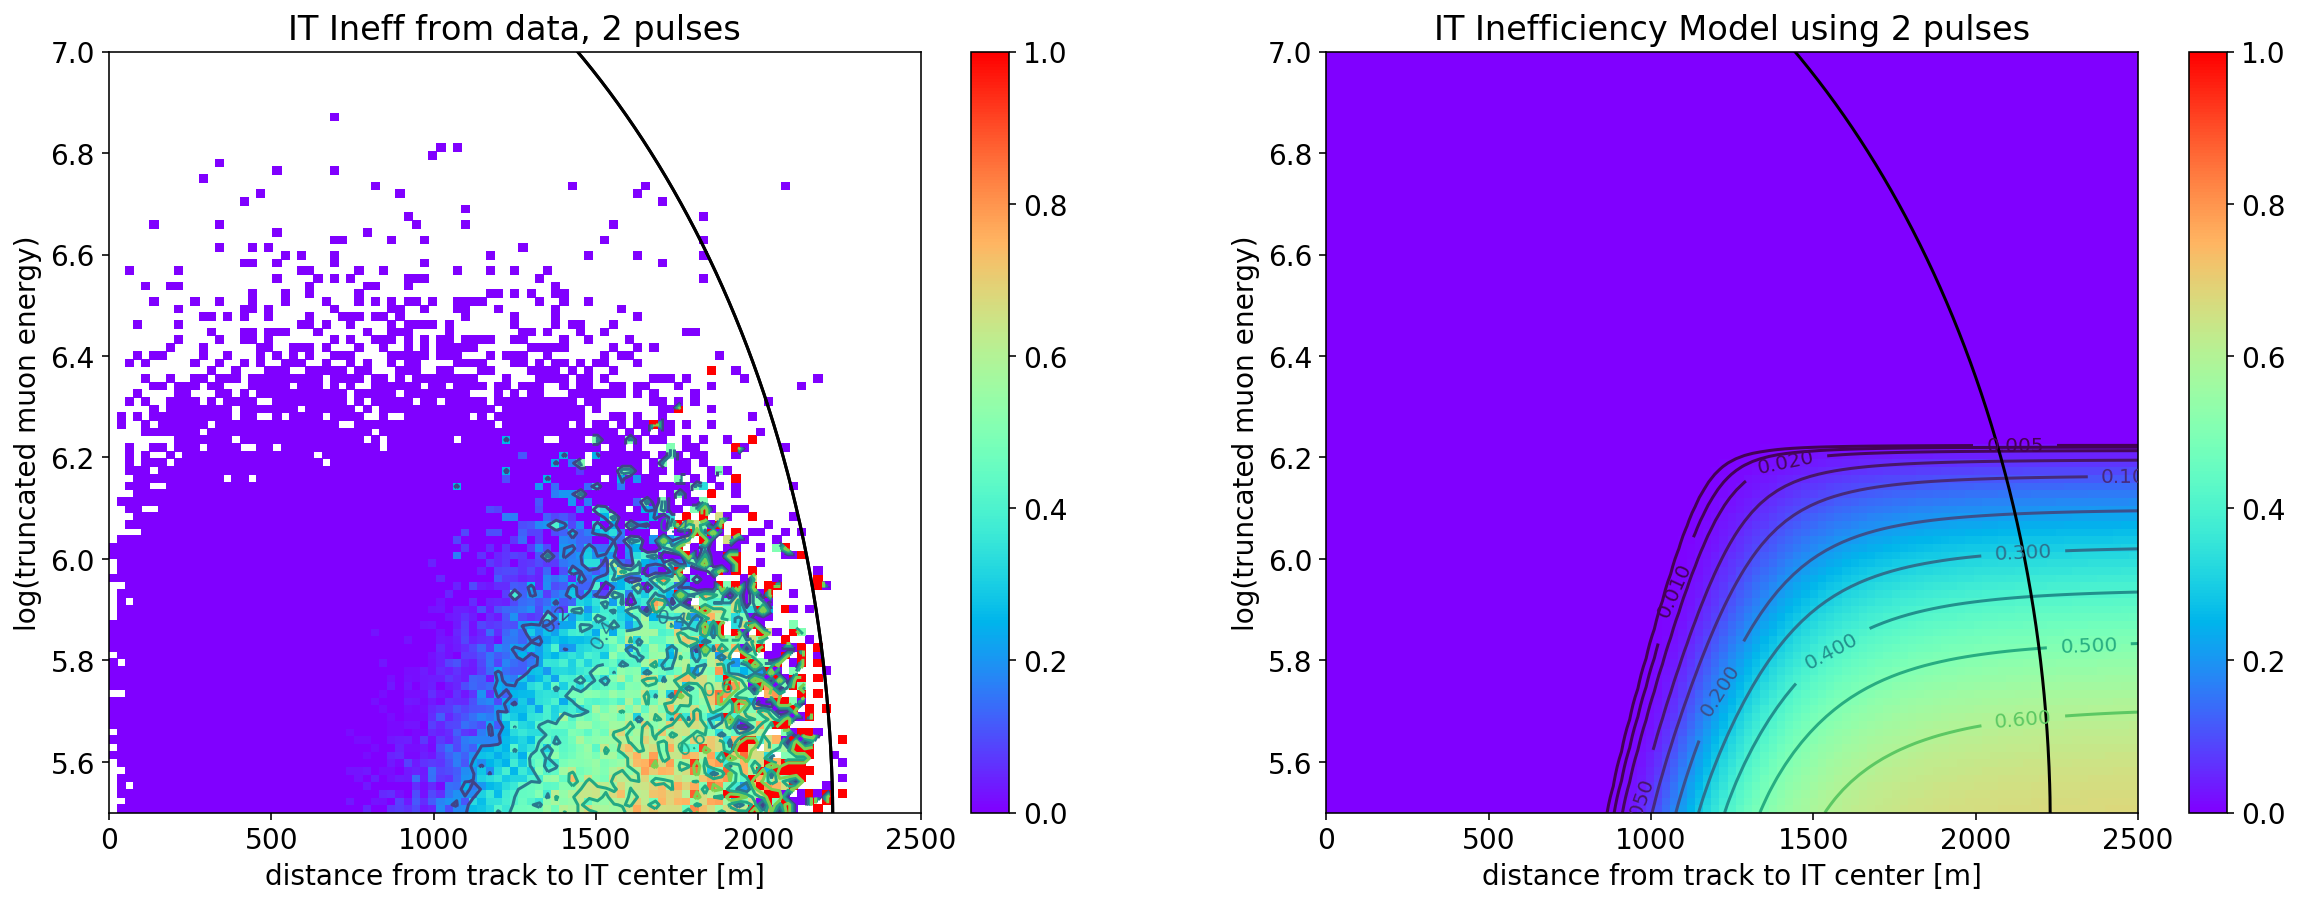

best exponent =  4.599999999999998
[-0.90684259  5.37653086  0.8110882 ]


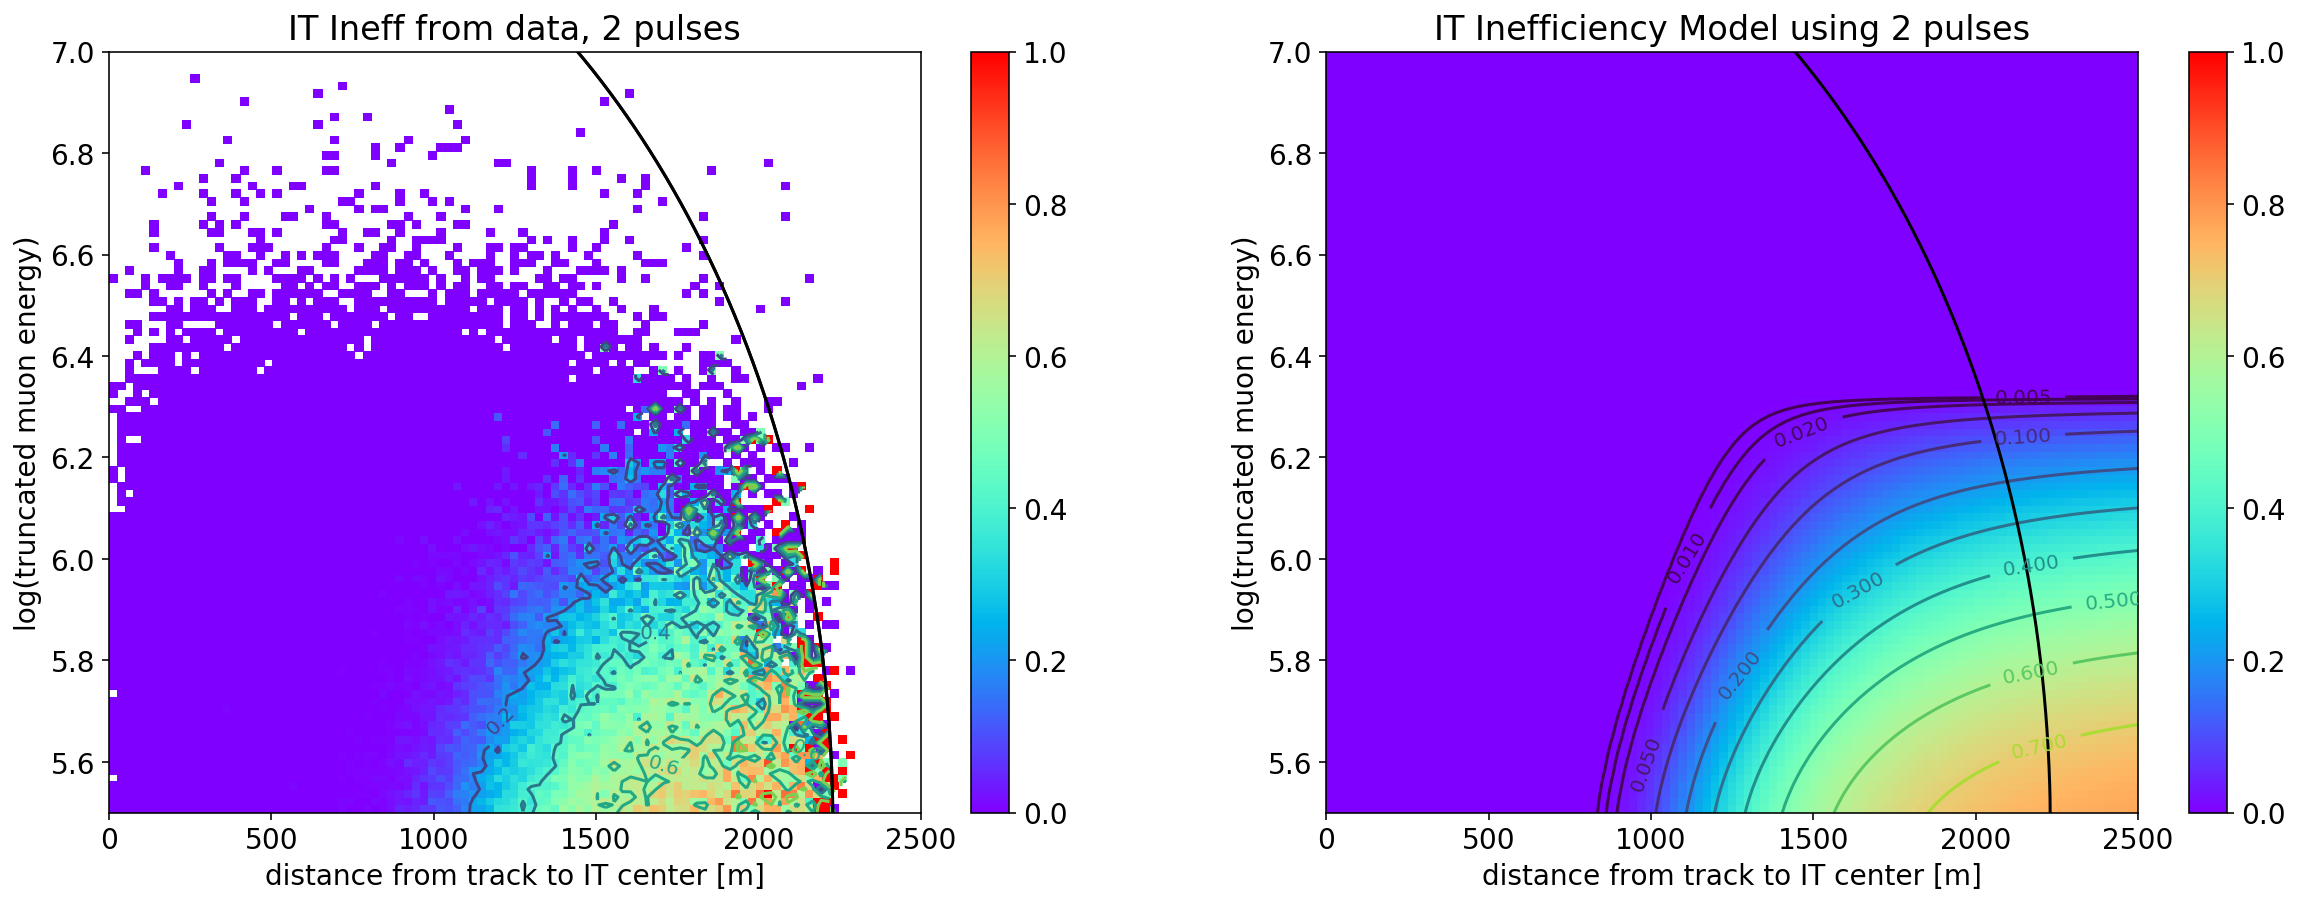

In [5]:
ineff_2012,cs_2012 = modeling('all_data_2012')
ineff_2013,cs_2013 = modeling('all_data_2013')
ineff_2014,cs_2014 = modeling('all_data_2014')
ineff_2015,cs_2015 = modeling('all_data_2015')
ineff_2016,cs_2016 = modeling('all_data_2016')
ineff_baseline,cs_baseline = modeling('data_full')

# check snow accumulation

In [6]:
# x = np.linspace(0.001,2500,100) # dist 
# y = np.linspace(5.5,7,100)  # E 
# xx,yy = np.meshgrid(xt,yt)
# xs,ys = xx.ravel(),yy.ravel()
# zz_2012 = ineff_2012(xx,yy)
# zz_2013 = ineff_2013(xx,yy)
# zz_2014 = ineff_2014(xx,yy)
# zz_2015 = ineff_2015(xx,yy)
# zz_2016 = ineff_2016(xx,yy)

# zs_2012 = zz_2012.ravel()
# zs_2013 = zz_2013.ravel()
# zs_2014 = zz_2014.ravel()
# zs_2015 = zz_2015.ravel()
# zs_2016 = zz_2016.ravel()

In [7]:
def show_contour(L):
    levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

    level_2012 = cs_2012.allsegs[L][0]
    level_2013 = cs_2013.allsegs[L][0]
    level_2014 = cs_2014.allsegs[L][0]
    level_2015 = cs_2015.allsegs[L][0]
    level_2016 = cs_2016.allsegs[L][0]
    level_baseline = cs_baseline.allsegs[L][0]

    plt.figure(figsize=(7,5))
    cmap = matplotlib.cm.get_cmap('rainbow_r')
    plt.plot(level_2012[:,0],level_2012[:,1],label='2012',color=cmap(0.0))
    plt.plot(level_2013[:,0],level_2013[:,1],label='2013',color=cmap(0.2))
    plt.plot(level_2014[:,0],level_2014[:,1],label='2014',color=cmap(0.4))
    plt.plot(level_2015[:,0],level_2015[:,1],label='2015',color=cmap(0.6))
    plt.plot(level_2016[:,0],level_2016[:,1],label='2016',color=cmap(0.8))
    plt.plot(level_baseline[:,0],level_baseline[:,1],'--',label='baseline',color='black')

    plt.title('contour: ineff = '+str(levels[L]))    
    plt.xlabel('distance from track to IT center [m]')
    plt.ylabel('log(truncated muon energy)')
    plt.xlim(0,2500)
    plt.ylim(5.5,7)
    plt.legend()
    plt.show()

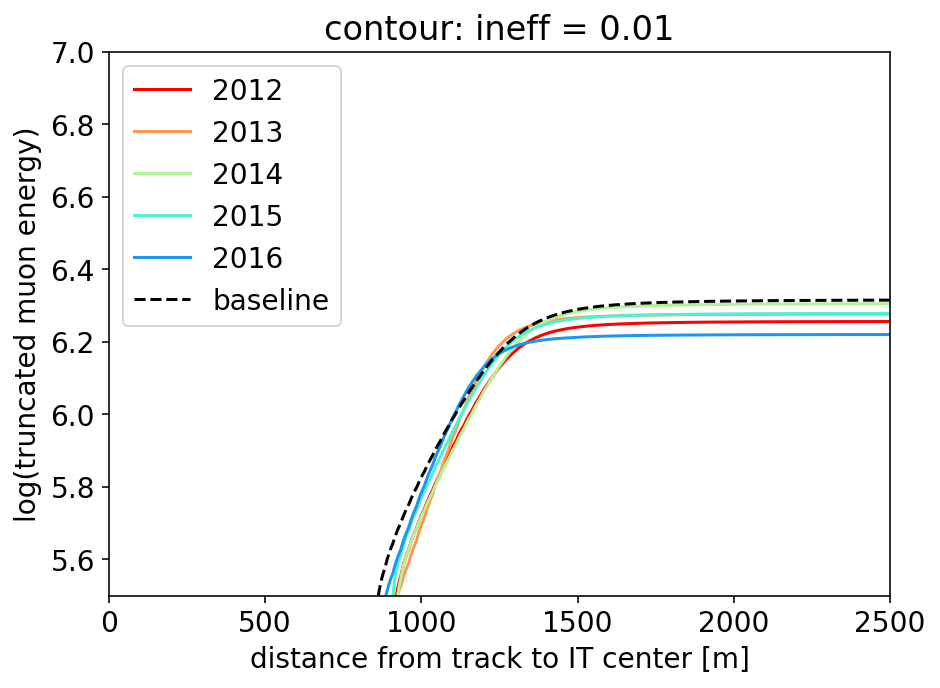

In [8]:
show_contour(1)

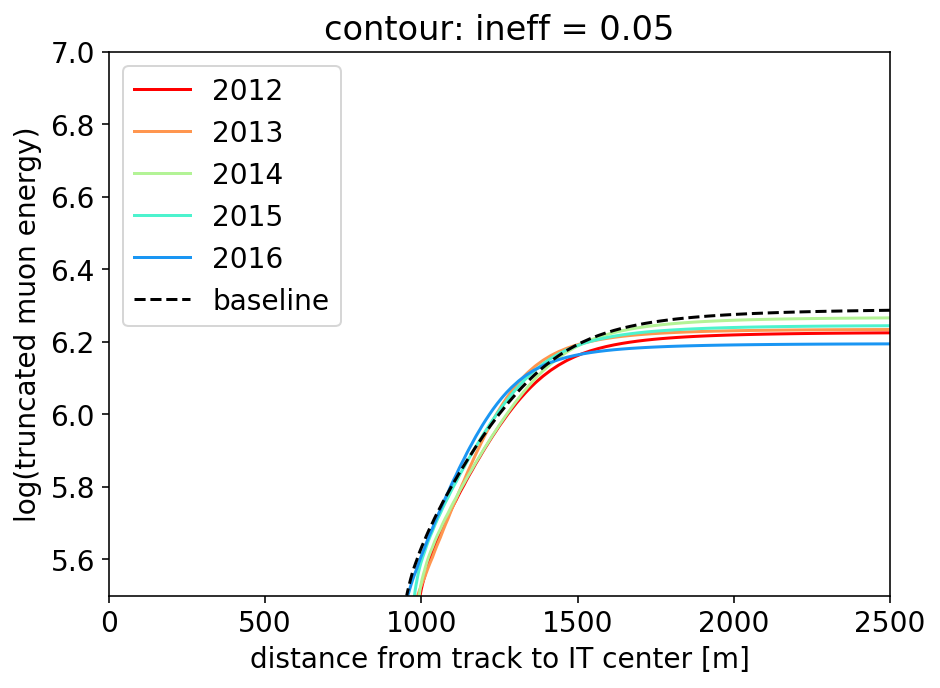

In [9]:
show_contour(3)

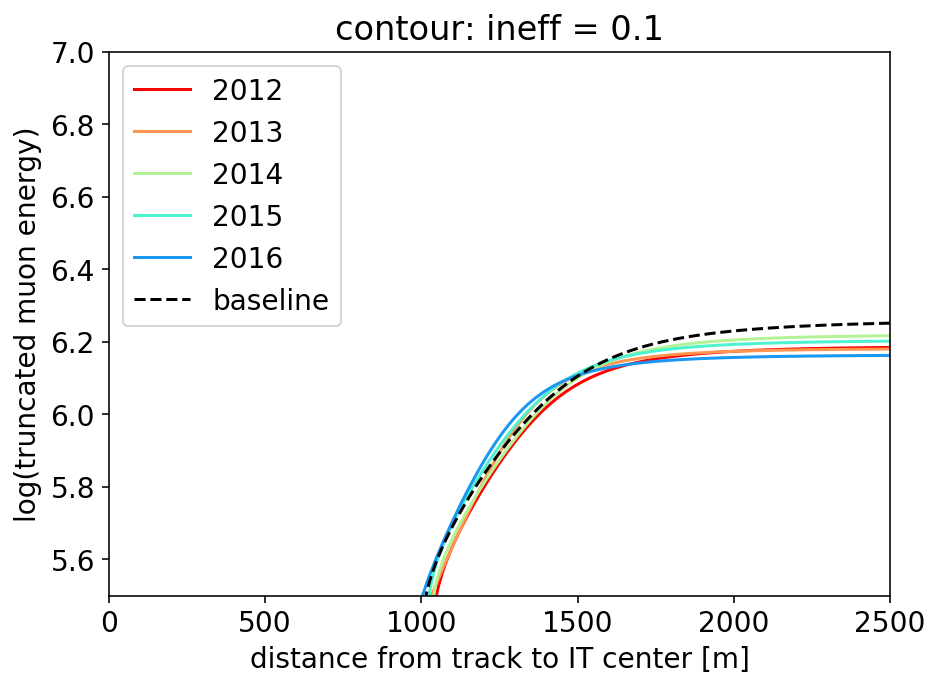

In [10]:
show_contour(4)

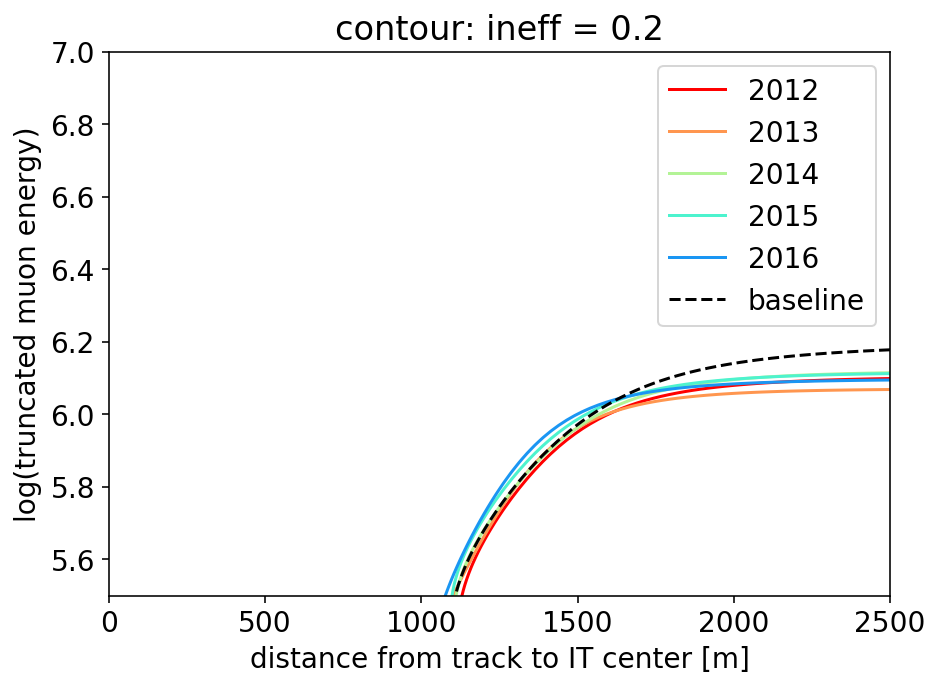

In [11]:
show_contour(5)

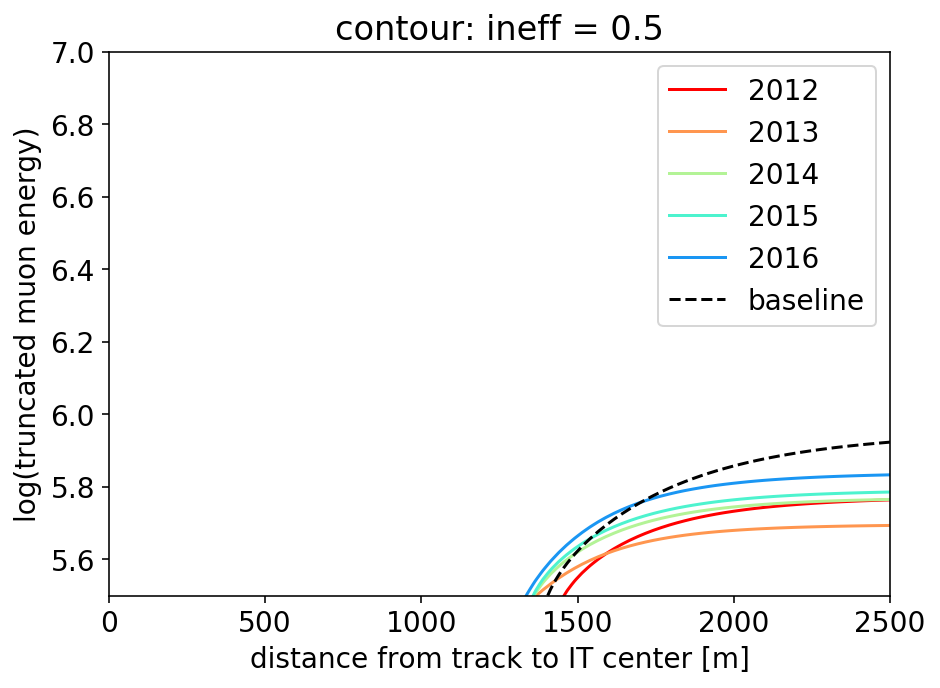

In [12]:
show_contour(8)

The size of inefficiency region is decreasing with snow accumulation! 

# effect on analysis 

In [13]:
# see how distribution of e.g. truncated change (after ineff and stoch cuts). 
# see if can parametrize the change as a function of snow depth / year...

In [14]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19017
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident
    
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_numu = f.root.Collection.cols.stoch[:][CUT]
    chi2_red_new_numu = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]

    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    Qtot_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_numu = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_numu = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_numu = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_numu = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_numu = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_numu = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_numu = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_numu = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_numu = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_numu = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_numu = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_numu = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
    coincidence_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.MCPrimary_new.cols.energy[:][CUT]
    zenith_truth_numu = f.root.MCPrimary_new.cols.zenith[:][CUT]

    weight_numu_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_numu_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

    runid_numu = f.root.FileNumber.cols.value[:][CUT]
    eventid_numu = f.root.FileNumber.cols.Event[:][CUT]  

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [15]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11981.h5','r') as f:
    n_file = 19996
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident
    
    chi2_red_nue = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_nue = f.root.Collection.cols.stoch[:][CUT]
    chi2_red_new_nue = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_nue = f.root.Collection.cols.PeakOverMedian[:][CUT]

    zenith_nue = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_nue = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_nue = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_nue = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_nue = f.root.QTot.cols.value[:][CUT]
    Qtot_nue = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_nue = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_nue = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_nue = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_nue = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_nue = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_nue = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_nue = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_nue = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_nue = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_nue = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_nue = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_nue = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    closest_d_nue = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_nue = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_nue = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_nue = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
    coincidence_nue = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_nue = f.root.MCPrimary_new.cols.energy[:][CUT]
    
    weight_nue_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_nue_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_nue_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

    runid_nue = f.root.FileNumber.cols.value[:][CUT]
    eventid_nue = f.root.FileNumber.cols.Event[:][CUT]    

In [16]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11477.h5','r') as f:
    n_file = 19914
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident
    
    chi2_red_nutau = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_nutau = f.root.Collection.cols.stoch[:][CUT]
    chi2_red_new_nutau = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_nutau = f.root.Collection.cols.PeakOverMedian[:][CUT]

    zenith_nutau = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_nutau = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_nutau = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_nutau = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_nutau = f.root.QTot.cols.value[:][CUT]
    Qtot_nutau = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_nutau = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_nutau = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_nutau = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_nutau = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_nutau = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_nutau = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_nutau = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_nutau = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_nutau = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_nutau = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_nutau = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_nutau = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    closest_d_nutau = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_nutau = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_nutau = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_nutau = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
    coincidence_nutau = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_nutau = f.root.MCPrimary_new.cols.energy[:][CUT]

    ### astrophysical ### 
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_nutau_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    

In [17]:
with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564]

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1

    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity
    
    chi2_data_burn = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    chi2_new_data_burn = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_data_burn = f.root.Collection.cols.PeakOverMean[:][CUT]
    stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)
    stoch_new_data_burn = np.log10(chi2_red_new_data_burn)/8 + np.log10(PeakOverMedian_data_burn)
    
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_data_burn = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_data_burn = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_data_burn = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_data_burn = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_data_burn = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_data_burn = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_data_burn = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_data_burn = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_data_burn = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_data_burn = f.root.CVMultiplicity.cols.n_pulses[:][CUT]

    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

    IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
    Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    runid_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
#     weight_data_burn = np.sum(weight_corsika)/np.sum(np.ones_like(zenith_data_burn)) * np.ones_like(zenith_data_burn)


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [18]:
def sumw2(b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

def variation(dist,trunc,stoch,var,weight,bins,name,xlabel):
    ineffcut = 0.02
    stochcut = 2.67
    
    CUT_2012 = (ineff_2012(dist,trunc)<ineffcut) & (stoch > stochcut)
    CUT_2013 = (ineff_2013(dist,trunc)<ineffcut) & (stoch > stochcut)
    CUT_2014 = (ineff_2014(dist,trunc)<ineffcut) & (stoch > stochcut)
    CUT_2015 = (ineff_2015(dist,trunc)<ineffcut) & (stoch > stochcut)
    CUT_2016 = (ineff_2016(dist,trunc)<ineffcut) & (stoch > stochcut)
    CUT_baseline = (ineff_baseline(dist,trunc)<ineffcut) & (stoch > stochcut)

    plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0.0, hspace=0.1)
    ax1 = plt.subplot(gs[0])
    
#     plt.hist(var[CUT_2012],weights=weight[CUT_2012],bins=np.linspace(5,9,30),label='2012 ineff',histtype='step',log=True) 
#     plt.hist(var[CUT_2013],weights=weight[CUT_2013],bins=np.linspace(5,9,30),label='2013 ineff',histtype='step',log=True)
#     plt.hist(var[CUT_2014],weights=weight[CUT_2014],bins=np.linspace(5,9,30),label='2014 ineff',histtype='step',log=True)
#     plt.hist(var[CUT_2015],weights=weight[CUT_2015],bins=np.linspace(5,9,30),label='2015 ineff',histtype='step',log=True)
#     plt.hist(var[CUT_2016],weights=weight[CUT_2016],bins=np.linspace(5,9,30),label='2016 ineff',histtype='step',log=True)

    h_2012,b_2012=np.histogram(var[CUT_2012],weights=weight[CUT_2012],bins=bins)
    h_2013,b_2013=np.histogram(var[CUT_2013],weights=weight[CUT_2013],bins=bins)
    h_2014,b_2014=np.histogram(var[CUT_2014],weights=weight[CUT_2014],bins=bins)
    h_2015,b_2015=np.histogram(var[CUT_2015],weights=weight[CUT_2015],bins=bins)
    h_2016,b_2016=np.histogram(var[CUT_2016],weights=weight[CUT_2016],bins=bins)
    h_baseline,b_baseline=np.histogram(var[CUT_baseline],weights=weight[CUT_baseline],bins=bins)

    err_2012 = np.sqrt(sumw2(bins,weight[CUT_2012],var[CUT_2012]))
    err_2013 = np.sqrt(sumw2(bins,weight[CUT_2013],var[CUT_2013]))
    err_2014 = np.sqrt(sumw2(bins,weight[CUT_2014],var[CUT_2014]))
    err_2015 = np.sqrt(sumw2(bins,weight[CUT_2015],var[CUT_2015]))
    err_2016 = np.sqrt(sumw2(bins,weight[CUT_2016],var[CUT_2016]))
    err_baseline = np.sqrt(sumw2(bins,weight[CUT_baseline],var[CUT_baseline]))

    cmap = matplotlib.cm.get_cmap('rainbow_r')
    delta = (bins[2]-bins[1])/15
    plt.errorbar((b_2012[1:]+b_2012[:-1])/2 + 0*delta,h_2012,yerr=err_2012,fmt='_',capsize=2,alpha=1,label='2012 ineff',color=cmap(0.0))
    plt.errorbar((b_2013[1:]+b_2013[:-1])/2 + 1*delta,h_2013,yerr=err_2013,fmt='_',capsize=2,alpha=1,label='2013 ineff',color=cmap(0.2))
    plt.errorbar((b_2014[1:]+b_2014[:-1])/2 + 2*delta,h_2014,yerr=err_2014,fmt='_',capsize=2,alpha=1,label='2014 ineff',color=cmap(0.4))
    plt.errorbar((b_2015[1:]+b_2015[:-1])/2 + 3*delta,h_2015,yerr=err_2015,fmt='_',capsize=2,alpha=1,label='2015 ineff',color=cmap(0.6))
    plt.errorbar((b_2016[1:]+b_2016[:-1])/2 + 4*delta,h_2016,yerr=err_2016,fmt='_',capsize=2,alpha=1,label='2016 ineff',color=cmap(0.8))
    plt.errorbar((b_baseline[1:]+b_baseline[:-1])/2 + 5*delta,h_baseline,yerr=err_baseline,fmt='_',capsize=2,alpha=1,label='baseline ineff',color='black')

    plt.title(name)
    plt.legend(prop={'size':9},loc='upper right')
    plt.yscale('log')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylabel('Events in 365 days')
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax1.tick_params(labelbottom=False)    

    ax2 = plt.subplot(gs[1])
    
    plt.scatter((b_2012[1:]+b_2012[:-1])/2, h_2012/h_baseline,facecolor='none',edgecolor=cmap(0.0),label='2012/baseline')
    plt.scatter((b_2013[1:]+b_2013[:-1])/2, h_2013/h_baseline,facecolor='none',edgecolor=cmap(0.2),label='2013/baseline')
    plt.scatter((b_2014[1:]+b_2014[:-1])/2, h_2014/h_baseline,facecolor='none',edgecolor=cmap(0.4),label='2014/baseline')
    plt.scatter((b_2015[1:]+b_2015[:-1])/2, h_2015/h_baseline,facecolor='none',edgecolor=cmap(0.6),label='2015/baseline')
    plt.scatter((b_2016[1:]+b_2016[:-1])/2, h_2016/h_baseline,facecolor='none',edgecolor=cmap(0.8),label='2016/baseline')

    plt.xlabel(xlabel)
    plt.ylim(0,2)
    plt.legend(prop={'size':6},loc='lower right')
    plt.xlim(np.min(bins),np.max(bins))
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    plt.axhline(1,ls='--',lw=1,color='black')
    plt.axhline(0.5,ls=':',lw=1,color='black')
    plt.axhline(1.5,ls=':',lw=1,color='black')
    
    plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


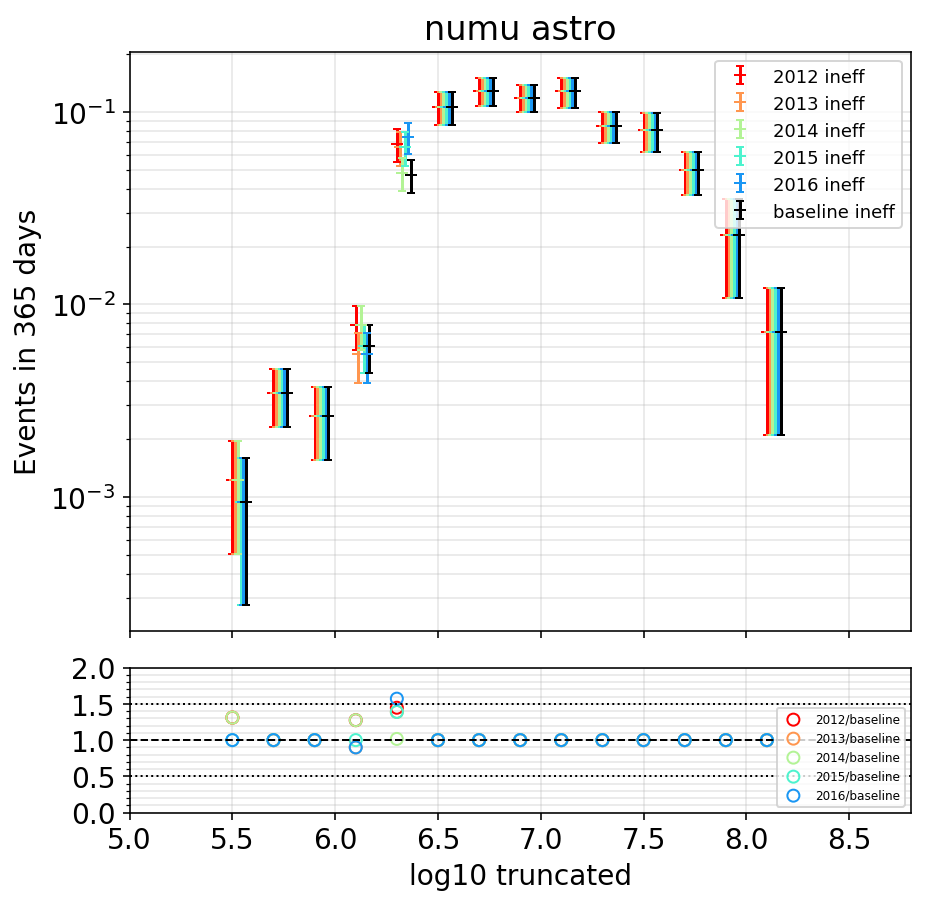

In [19]:
variation(d_to_IT_center_numu,
          np.log10(truncated_muon_e_numu),
          np.log10(chi2_red_new_numu),
          np.log10(truncated_muon_e_numu),
          weight_numu_astro,
          np.arange(5,9,0.2),
          'numu astro',
          'log10 truncated',
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


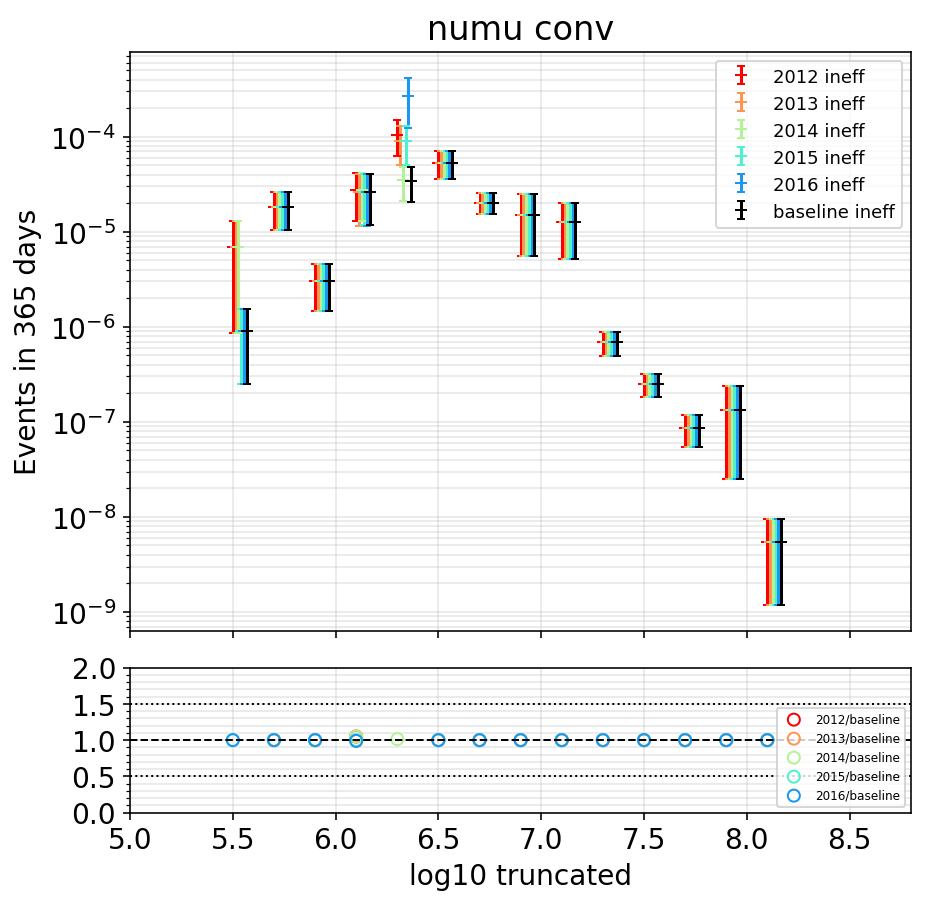

In [20]:
variation(d_to_IT_center_numu,
          np.log10(truncated_muon_e_numu),
          np.log10(chi2_red_new_numu),
          np.log10(truncated_muon_e_numu),
          weight_numu_conv,
          np.arange(5,9,0.2),
          'numu conv',
          'log10 truncated',
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


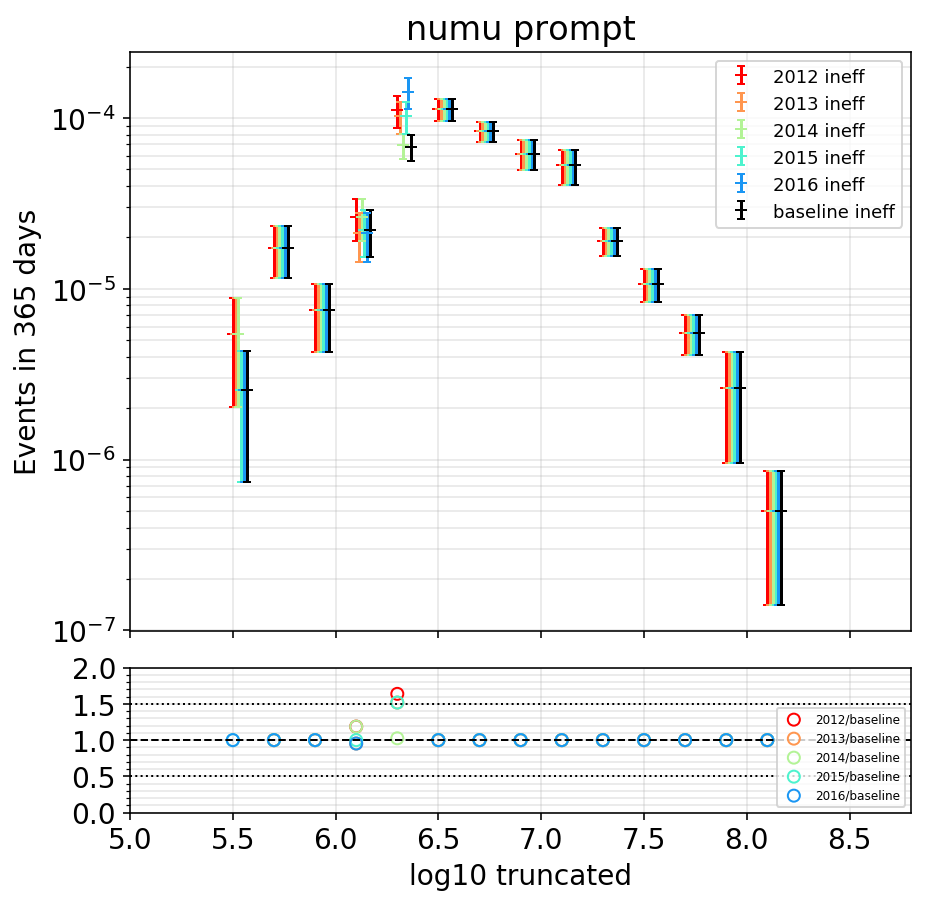

In [21]:
variation(d_to_IT_center_numu,
          np.log10(truncated_muon_e_numu),
          np.log10(chi2_red_new_numu),
          np.log10(truncated_muon_e_numu),
          weight_numu_prompt,
          np.arange(5,9,0.2),
          'numu prompt',
          'log10 truncated',
         )

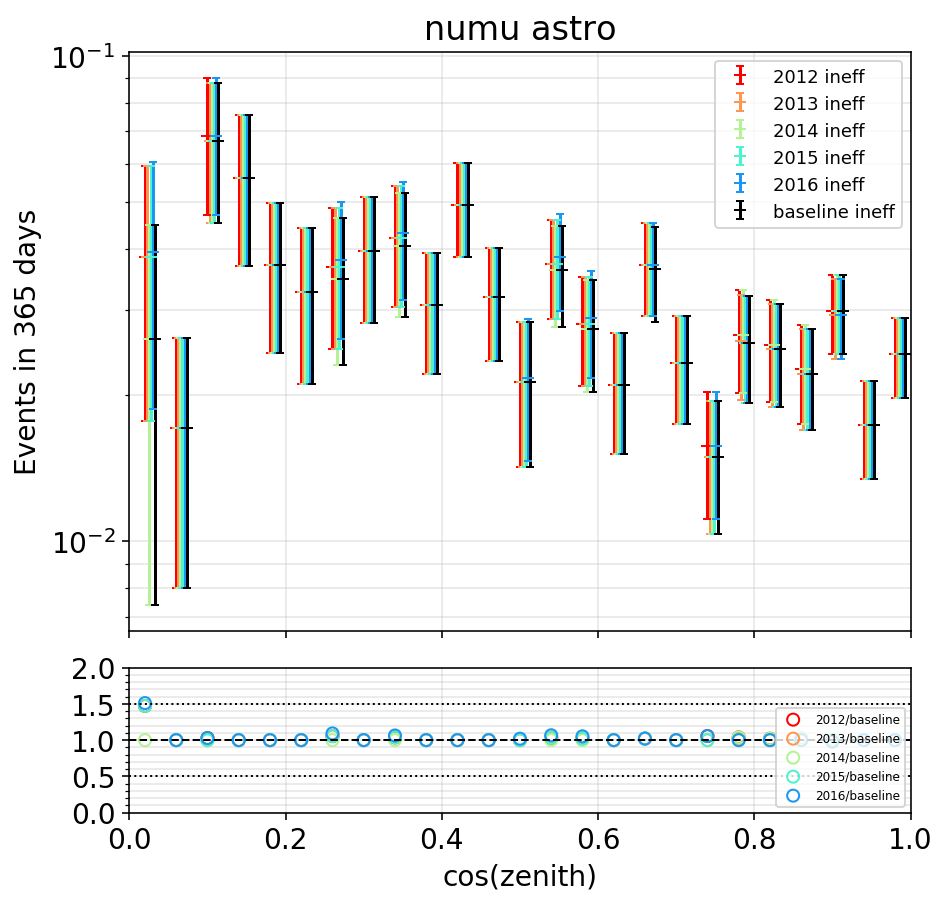

In [22]:
variation(d_to_IT_center_numu,
          np.log10(truncated_muon_e_numu),
          np.log10(chi2_red_new_numu),
          np.cos(zenith_numu),
          weight_numu_astro,
          np.arange(0,1.04,0.04),
          'numu astro',
          'cos(zenith)'
         )

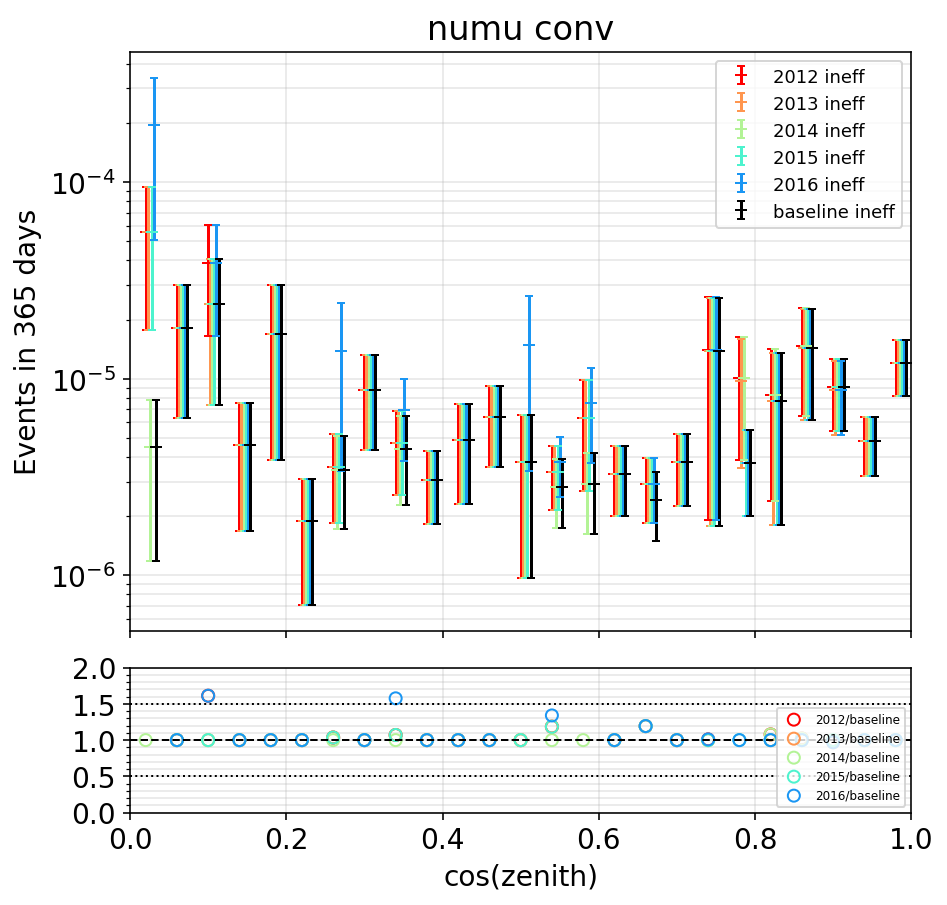

In [23]:
variation(d_to_IT_center_numu,
          np.log10(truncated_muon_e_numu),
          np.log10(chi2_red_new_numu),
          np.cos(zenith_numu),
          weight_numu_conv,
          np.arange(0,1.04,0.04),
          'numu conv',
          'cos(zenith)'
         )

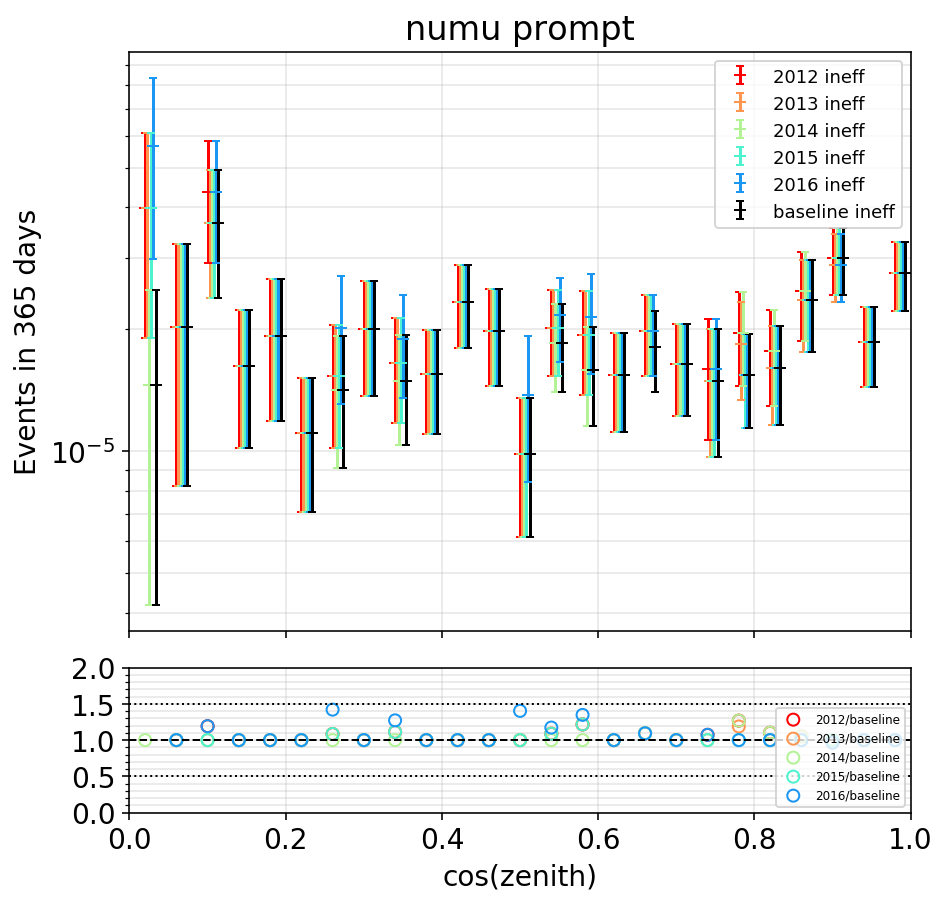

In [24]:
variation(d_to_IT_center_numu,
          np.log10(truncated_muon_e_numu),
          np.log10(chi2_red_new_numu),
          np.cos(zenith_numu),
          weight_numu_prompt,
          np.arange(0,1.04,0.04),
          'numu prompt',
          'cos(zenith)'
         )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


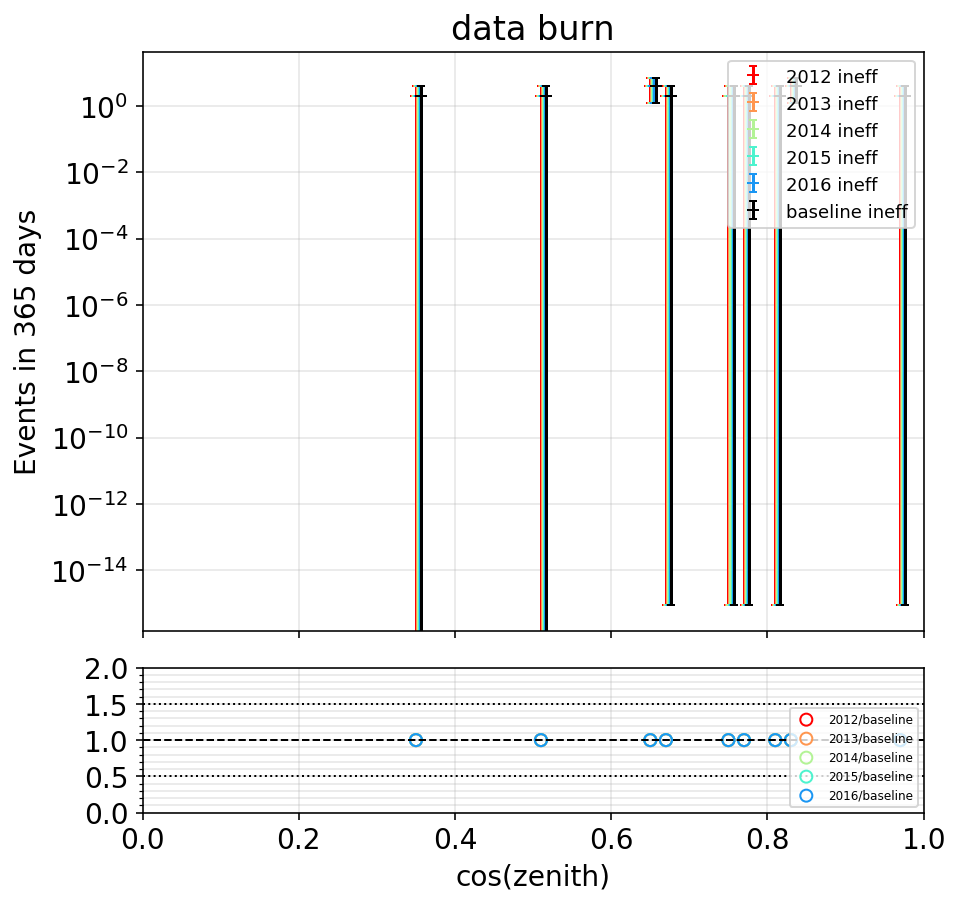

In [25]:
variation(d_to_IT_center_data_burn,
          np.log10(truncated_muon_e_data_burn),
          np.log10(chi2_red_new_data_burn),
          np.cos(zenith_data_burn),
          weight_data_burn,
          np.arange(0,1.02,0.02),
          'data burn',
          'cos(zenith)'
         )